# EventDisplay -- to display mPMT events in new npz file format

Edit to input the full geometry file, and npz data file that your are interested in.


Authors: Blair Jamieson, Connor Boubard


June 2020

In [1]:

import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import math
import random

In [2]:

datafile = np.load('IWCDmPMT_4pi_full_tank_mu-_E0to1000MeV_unif-pos-R371-y521cm_4pi-dir_3000evts_25.npz',allow_pickle=True)
geofile = np.load('full_geo_dump.npz',allow_pickle=True)


# First let's explore the geometry file
Make sure we can find the phototube locations, and build a mapping from the three dimensional locations of the PMTs.

In [3]:
geofile.files

['tube_no', 'position', 'orientation']

In [4]:
tubes = geofile[ 'tube_no' ]
tubes

array([    1,     2,     3, ..., 15806, 15807, 15808])

In [5]:
tube_xyz = geofile[ 'position' ]
tube_x = tube_xyz[:,0]
tube_y = tube_xyz[:,1]
tube_z = tube_xyz[:,2]
R =  (tube_x.max() - tube_x.min())/2.0
print("R=",R)
print( "min_x=",tube_x.min(), "max_x=", tube_x.max(), "diameter=", tube_x.max() - tube_x.min() )
print( "min_z=",tube_z.min(), "max_z=", tube_z.max(), "diameter=", tube_z.max() - tube_z.min() )
print( "min_y=",tube_y.min(), "max_y=", tube_y.max(), "height=", tube_y.max() - tube_y.min() )

R= 370.0958251953125
min_x= -370.0958251953125 max_x= 370.0958251953125 diameter= 740.191650390625
min_z= -370.0958251953125 max_z= 370.0958251953125 diameter= 740.191650390625
min_y= -517.4490356445312 max_y= 517.4490356445312 height= 1034.8980712890625


In [6]:
tube_dir = geofile[ 'orientation']

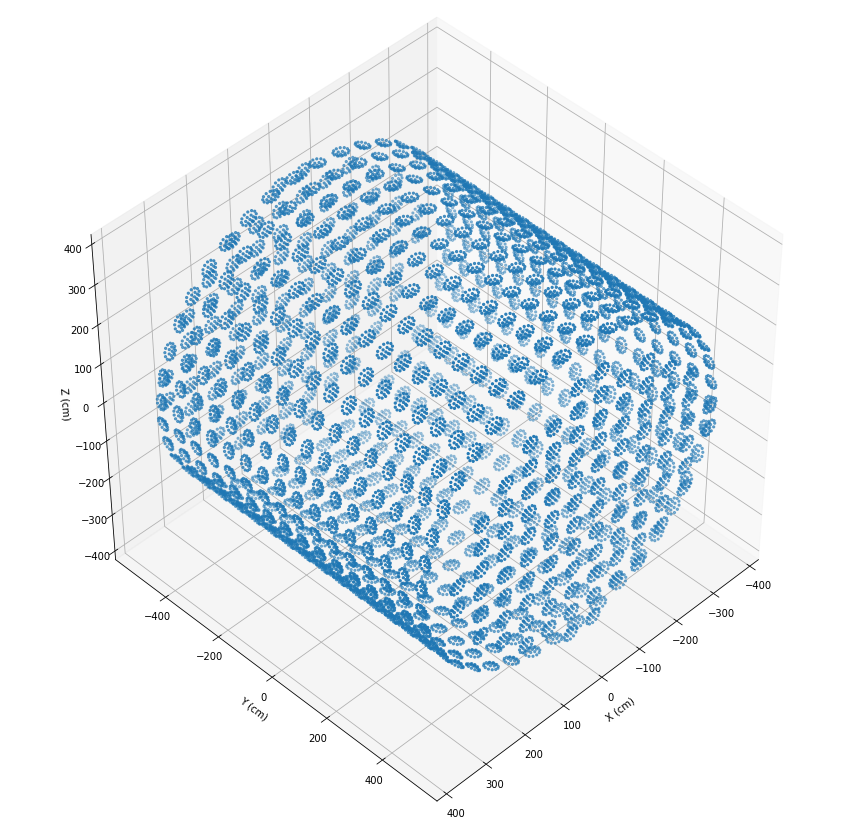

In [7]:

fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111, projection='3d')
ax.scatter( tube_x, tube_y, tube_z, marker='.'  )
ax.set_xlabel('X (cm)')
ax.set_ylabel('Y (cm)')
ax.set_zlabel('Z (cm)')
ax.view_init(elev=45.0, azim=45.0)
plt.show()


In [8]:


def PMT_to_flat_cylinder_mapping( tubes, tube_xyz ):
    """
    Build dictionary of PMT number, to (x,y) on a flat cylinder
    
    N.B. Tube numbers in full geometry file go from 1:NPMTs, but it seems like
    the event data number from 0:NPMTs-1, so subtracting 1 from tube number here?
    """
    mapping = {}
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( y > 500. ):
            # in top circle of cylinder
            xflat = x
            yflat = 897.6 + z
            mapping[ int( tube-1 ) ] = [ xflat, yflat ]
            
        elif ( y < -500.):
            # in bottom circle of cylinder
            xflat = x
            yflat = -897.6 + z
            mapping[ int( tube-1 ) ] = [ xflat, yflat ]
            
        else:
            # in barrel part of cylinder
            theta = math.atan2( z, x )
            xflat = R * theta
            yflat = y
            mapping[ int( tube-1 ) ] = [ xflat, yflat ]
    return mapping

PMTFlatMapping = PMT_to_flat_cylinder_mapping( tubes, tube_xyz )


In [9]:
def PMT_to_flat_cylinder_map_positive( tubes, tube_xyz ):
    """
    Build dictionary of PMT number, to (x,y) on a flat cylinder
    
    N.B. Tube numbers in full geometry file go from 1:NPMTs, but it seems like
    the event data number from 0:NPMTs-1, so subtracting 1 from tube number here?
    
    """
    mapping = {}
    for idx, tube in enumerate(tubes):
        x = tube_xyz[idx,0]
        y = tube_xyz[idx,1]
        z = tube_xyz[idx,2]
        if ( y > 500. ):
            # in top circle of cylinder
            xflat = x+1162.7
            yflat = 2165.2 + z
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        elif ( y < -500.):
            # in bottom circle of cylinder
            xflat = x+1162.7
            yflat = 370.1 + z
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
            
        else:
            # in barrel part of cylinder
            theta = math.atan2( z, x )
            xflat = R * theta + 1162.7
            yflat = y + 1267.7
            mapping[ int( tube-1 ) ] = [ int(round(xflat)), int(round(yflat)) ]
    return mapping

PMTFlatMapPositive = PMT_to_flat_cylinder_map_positive( tubes, tube_xyz )


#PMTFlatMapPositive

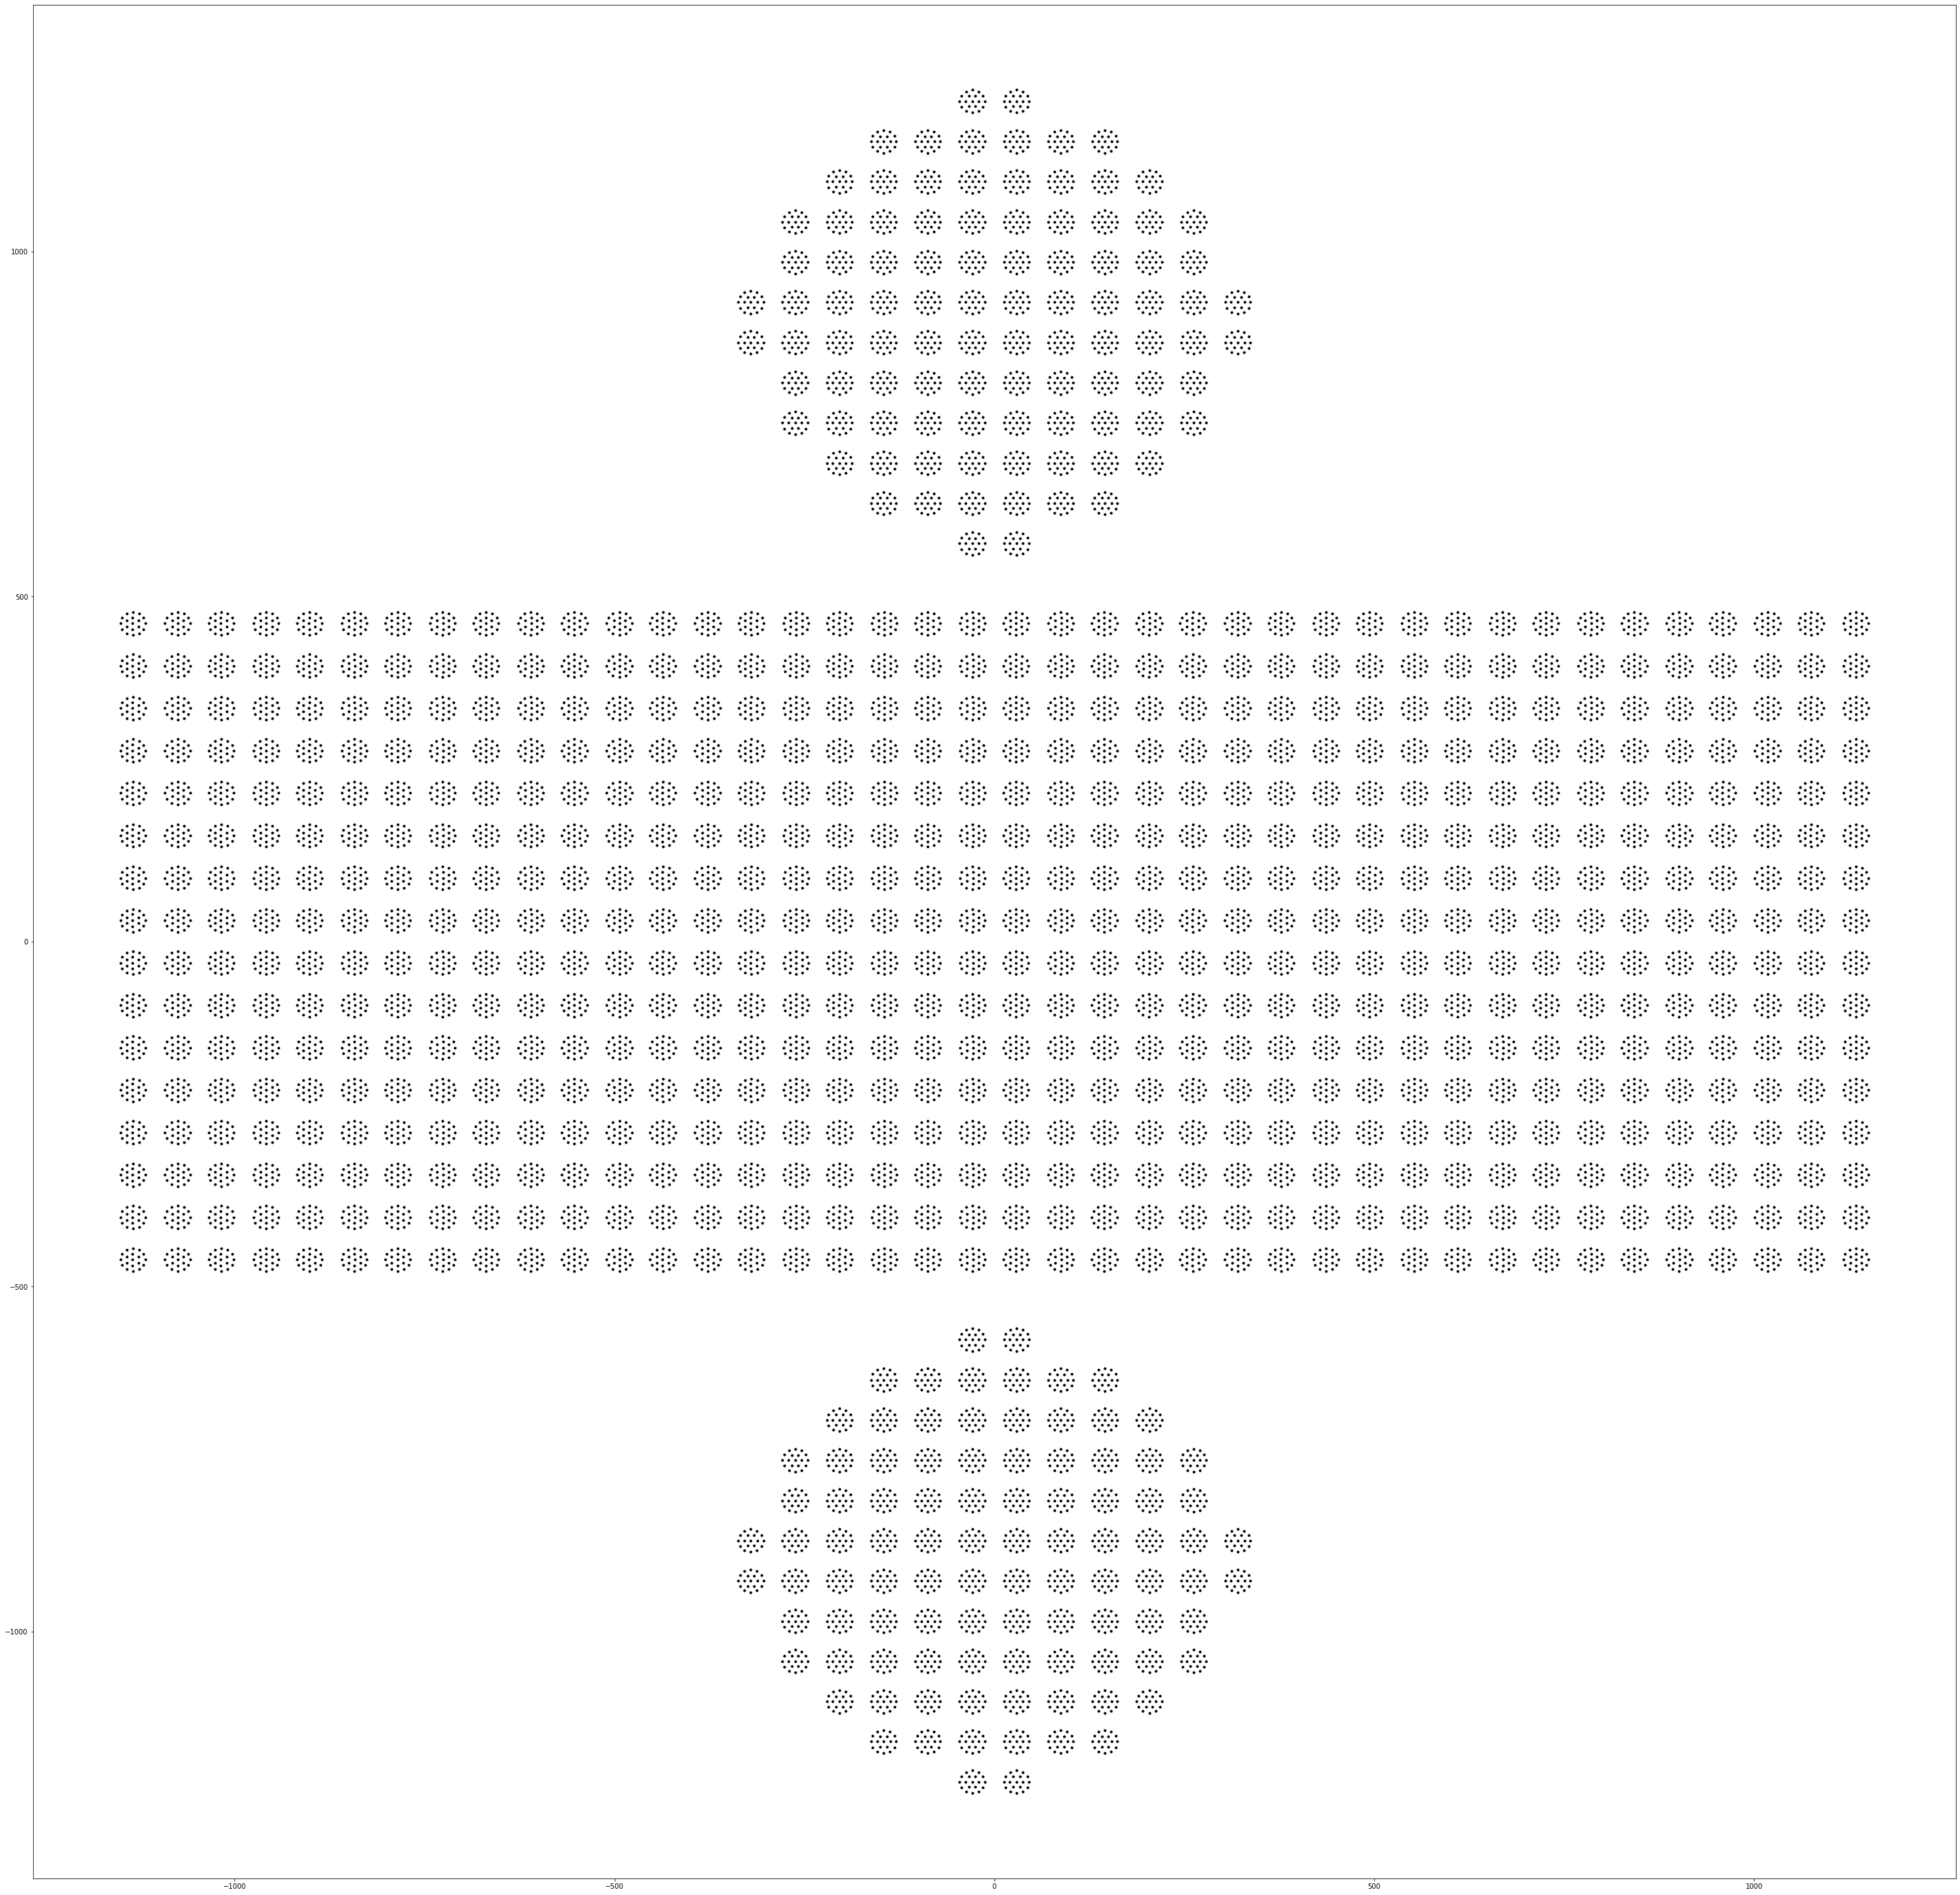

In [10]:
xflatvals = []
yflatvals = []
for tube in PMTFlatMapping:
    xflatvals.append( PMTFlatMapping[tube][0] )
    yflatvals.append( PMTFlatMapping[tube][1] )

fig = plt.figure(figsize=[50,50])    
plt.plot( xflatvals, yflatvals, '.', color='black' )
#uncomment the following line to save the image to a pdf file
#plt.savefig( 'mpmt_flatmap_positions.pdf')

Try making plot of PMT locations as image map

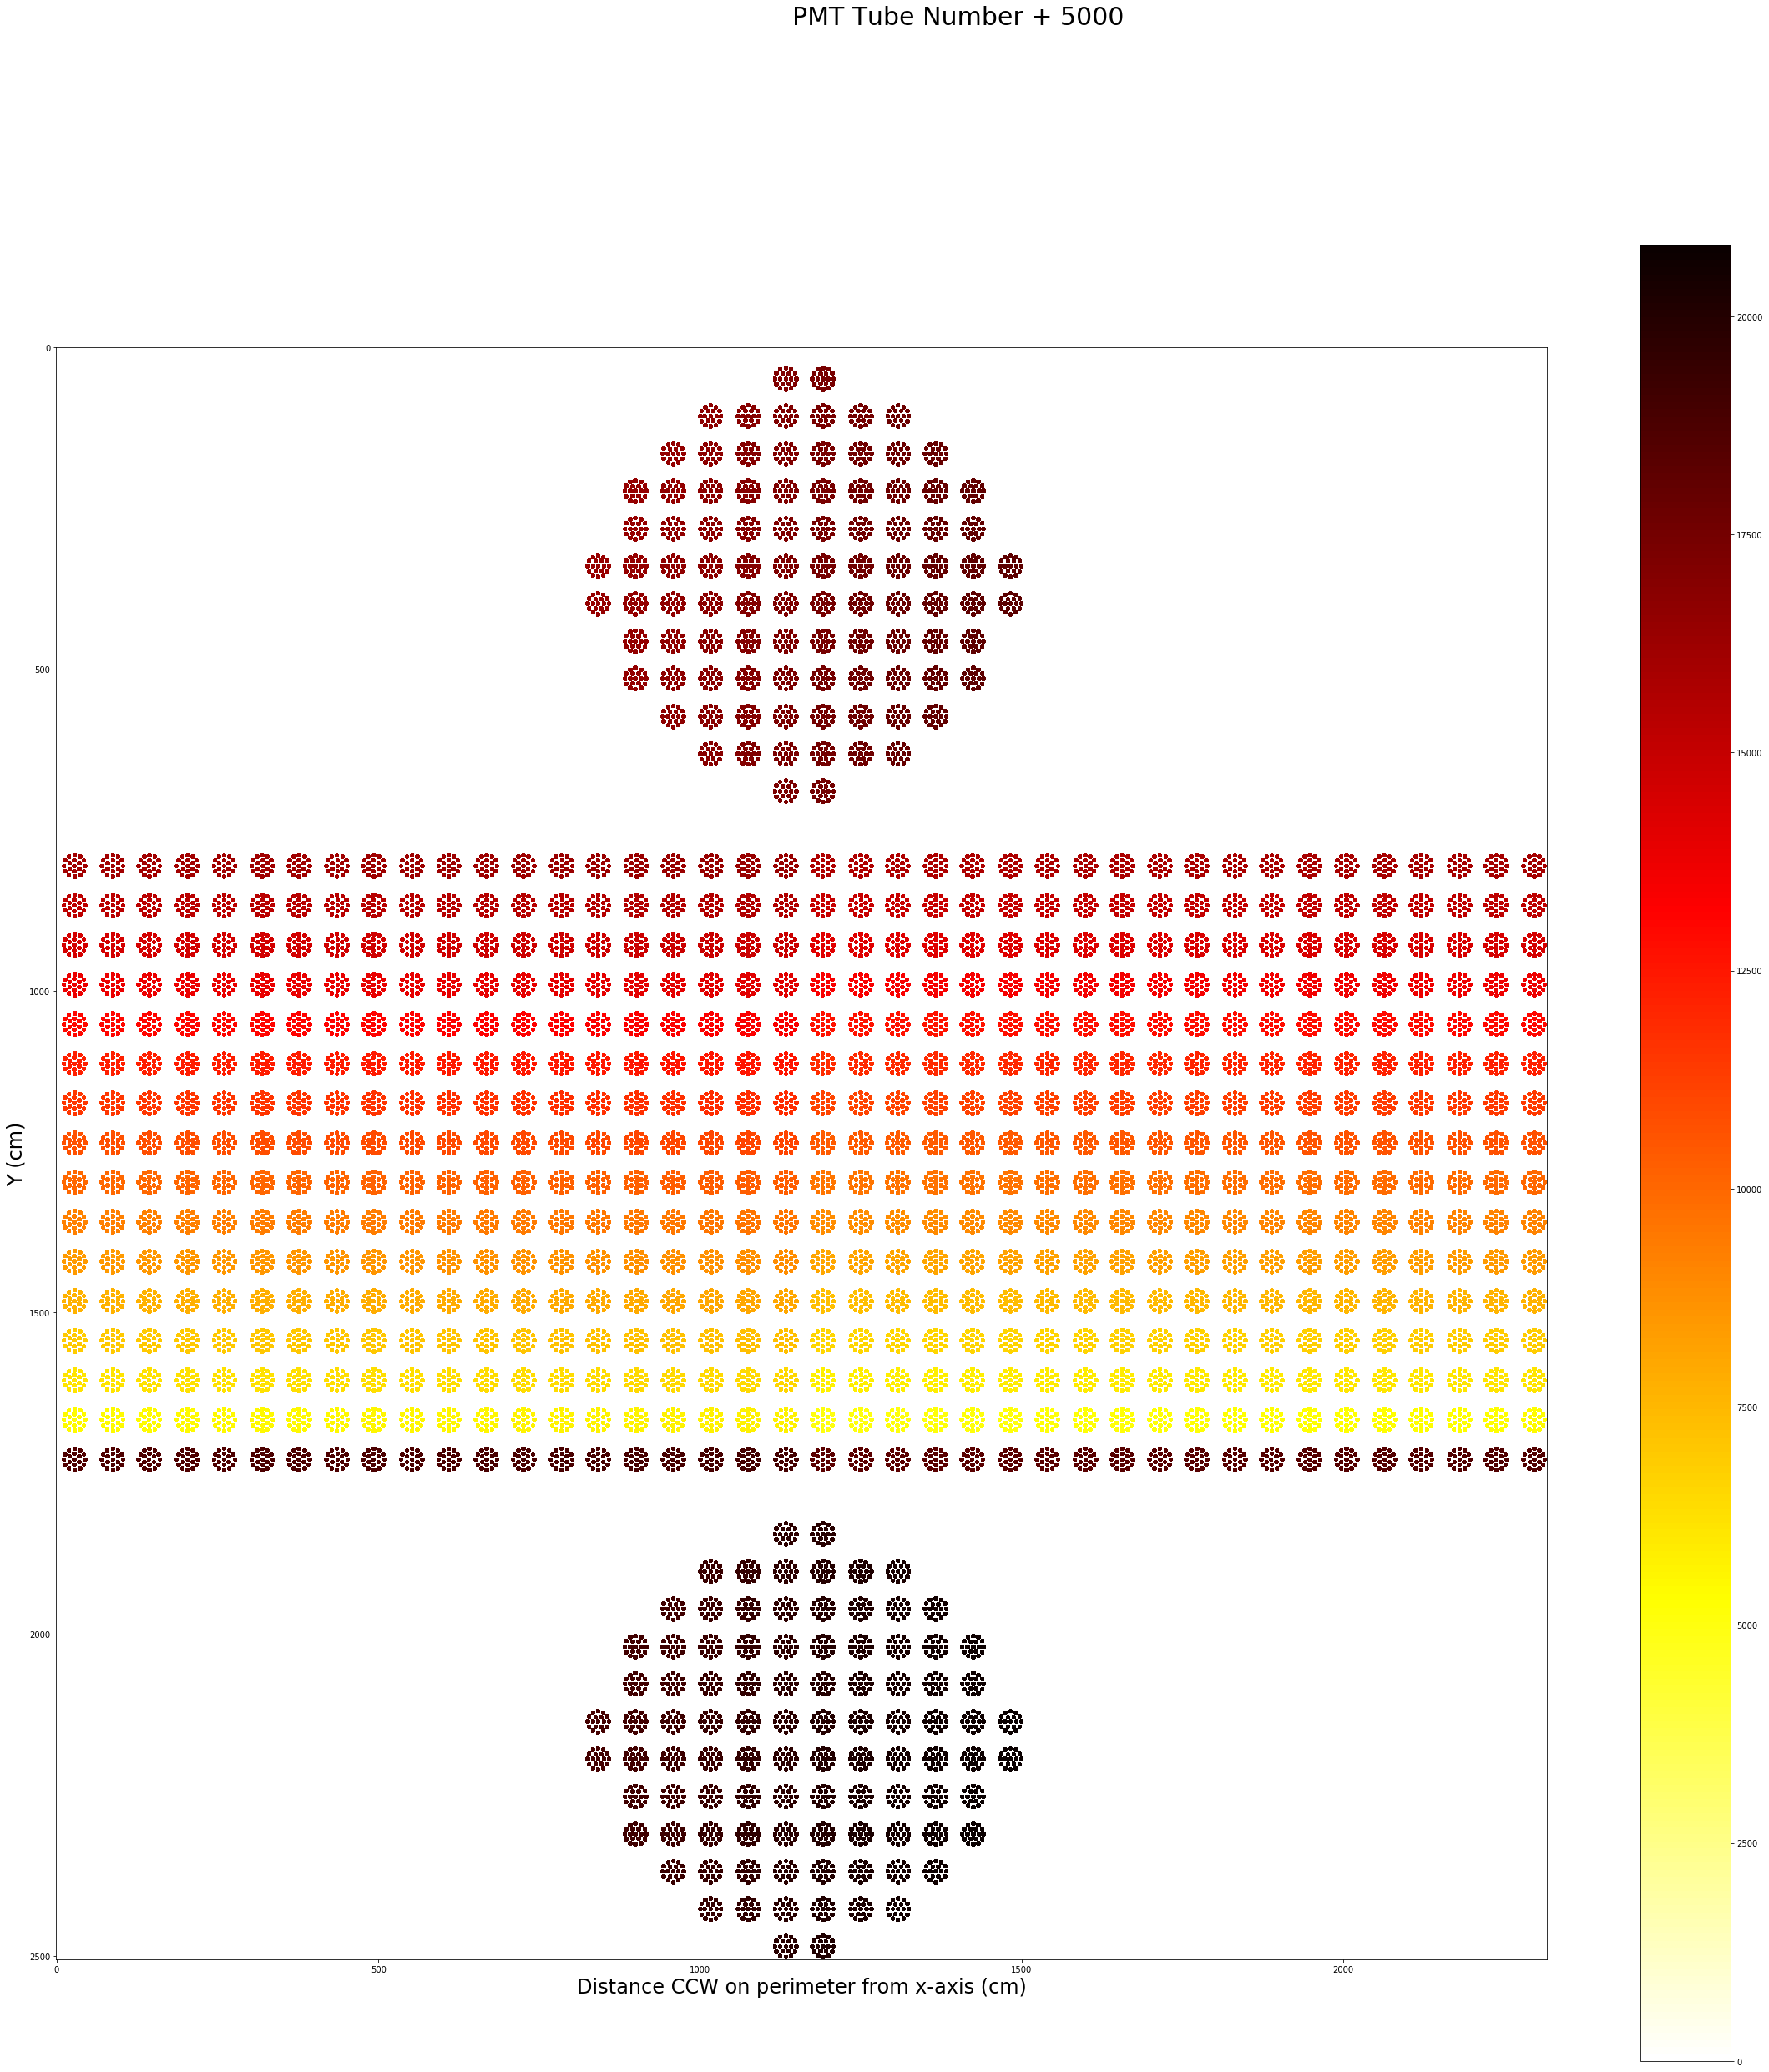

In [11]:
fig = plt.figure(figsize=[40,40]) 

preimage = np.zeros( [2506, 2317] )
for tube in PMTFlatMapPositive:
    for dx in range(-3,4):
        for dy in range(-3,4):
            if abs(dx)==3 and abs(dy)==3:
                continue
            preimage[ PMTFlatMapPositive[tube][1]+dx, PMTFlatMapPositive[tube][0]+dy ] = tube + 5000
plt.imshow( preimage )
fig.suptitle('PMT Tube Number + 5000',fontsize=30)
plt.xlabel('Distance CCW on perimeter from x-axis (cm)', fontsize=24)
plt.ylabel('Y (cm)', fontsize=24)
#plt.set_cmap('Greys')
plt.set_cmap('hot_r')
#plt.set_cmap('gist_heat_r')
plt.colorbar()
#plt.savefig( 'mpmt_flatmap_positions_img.pdf',dpi=300)

# Now lets look at a few events

Need to explore contents of event data, and make presentations of that data.  Things to present are:

- Time of hits on each PMT
- Charge of hits on each PMT

In [12]:
datafile.files

['event_id',
 'root_file',
 'pid',
 'position',
 'direction',
 'energy',
 'digi_hit_pmt',
 'digi_hit_charge',
 'digi_hit_time',
 'digi_hit_trigger',
 'true_hit_pmt',
 'true_hit_time',
 'true_hit_pos',
 'true_hit_start_time',
 'true_hit_start_pos',
 'true_hit_parent',
 'track_id',
 'track_pid',
 'track_start_time',
 'track_energy',
 'track_start_position',
 'track_stop_position',
 'track_parent',
 'track_flag',
 'trigger_time']

In [13]:
evno = 0
digitubes = datafile[ 'digi_hit_pmt' ][ evno ]
digicharges = datafile[ 'digi_hit_charge' ][ evno ]
digitimes = datafile[ 'digi_hit_time' ][ evno ]

In [14]:
number_of_events = len( datafile['digi_hit_pmt'] )
number_of_events

3000

In [15]:
digicharges

array([1.37697923, 1.2979815 , 6.64122343, ..., 1.10078454, 1.13121176,
       0.77738458])

In [16]:
digitubes

array([15085,  8459, 15083, ...,  2845,  8118,  4549], dtype=int32)

In [17]:
len(digitubes)

2174

In [18]:
len(digicharges)

2174

In [19]:
def EventDisplay( tubes, quantities, title="Charge", cutrange=[-1,-1] ):
    """
    tubes == np.array of PMTs that were hit
    quantities == np.array of PMT quantities (either charge or time)
    title == title to add to display
    cutrange == minimum and maximum values on plot (or set both same for default)
    """
    
    fig = plt.figure(figsize=[12,12]) 
    preimage = np.zeros( [2506, 2317] )
    #maxquantity = quantities.max()
    #preimage *= maxquantity*1.2
    imgmin = quantities.min()
    imgmax = quantities.max()
    for idx, tube in enumerate( tubes ):
        if cutrange[0] != cutrange[1]:
            if quantities[idx] < cutrange[0] or quantities[idx] > cutrange[1]:
                continue
        for dx in range(-3,4):
            for dy in range(-3,4):
                if abs(dx)==3 and abs(dy)==3:
                    continue
                    
                #print( "idx=", idx, " len(quantities)=",len(quantities), " tube=", tube, " len(PMTFlatMap)=", len(PMTFlatMapPositive))
                preimage[ PMTFlatMapPositive[tube][1]+dx, PMTFlatMapPositive[tube][0]+dy ] = quantities[idx]

    if cutrange[0] != cutrange[1]:
        imgmin = cutrange[0]
        imgmax = cutrange[1]
    plt.imshow( preimage, extent = [-1162.7,1162.7,-1267.7,1267.7], vmin=imgmin, vmax=imgmax )
    fig.suptitle(title, fontsize=20)
    plt.xlabel('Distance CCW on perimeter from x-axis (cm)', fontsize=18)
    plt.ylabel('Y (cm)', fontsize=16)
    #plt.set_cmap('YlGnBu')
    #plt.set_cmap('cubehelix_r')
    #plt.set_cmap('gnuplot2_r')
    plt.set_cmap('gist_heat_r')
    plt.colorbar()
    


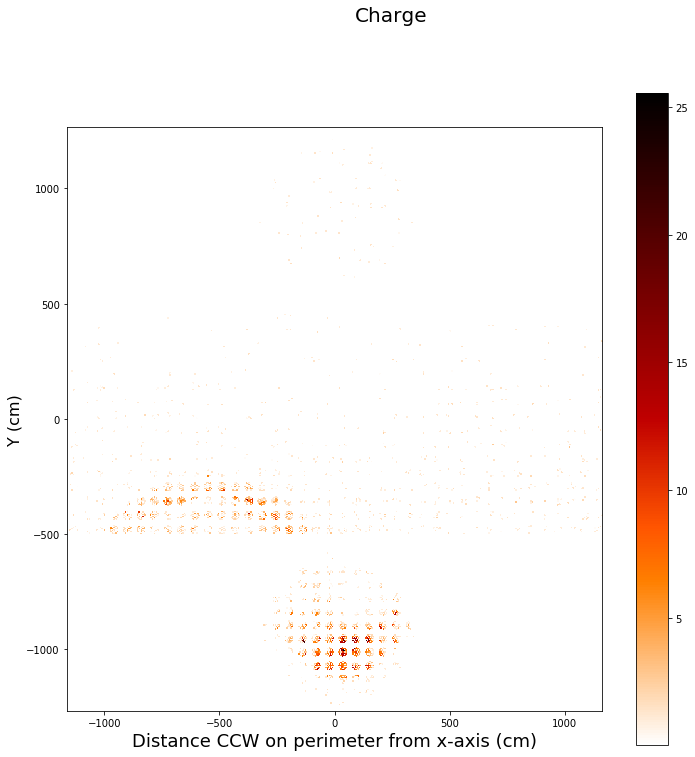

In [20]:
EventDisplay( digitubes, digicharges )
#uncomment following line to make pdf image
#plt.savefig( 'event0_charge.pdf',dpi=300)

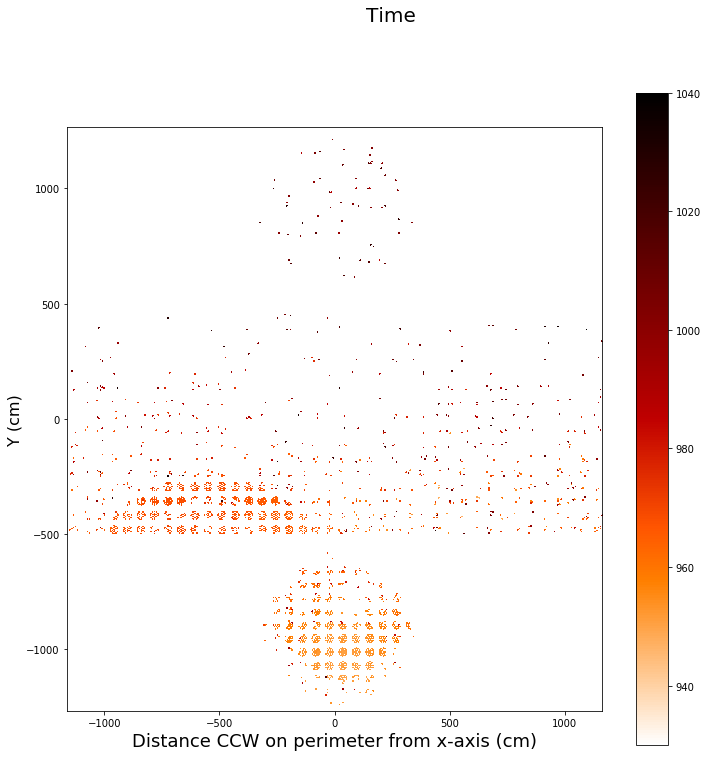

In [21]:
EventDisplay( digitubes, digitimes, "Time" , [930, 1040] )
#plt.savefig( 'event0_time.pdf',dpi=300)

# Make histograms of the charge and time distributions



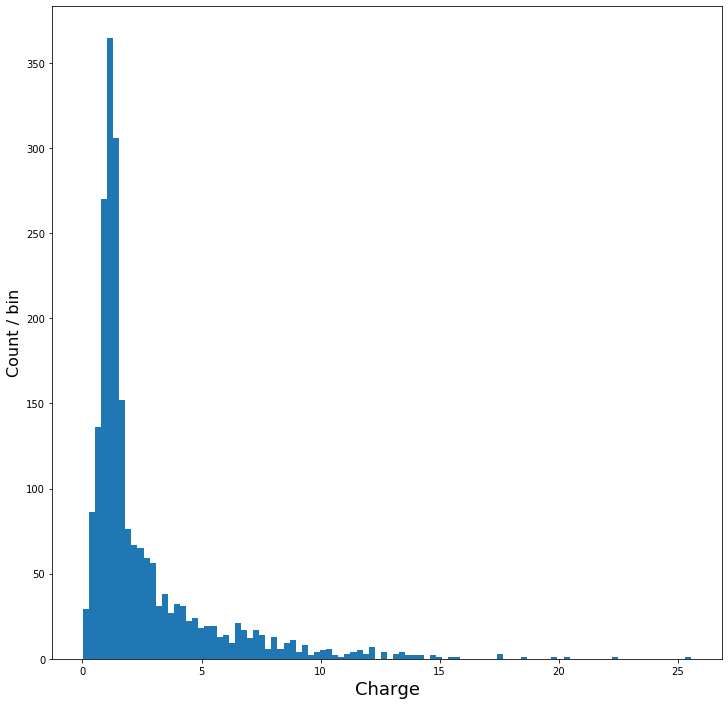

In [22]:
def EventDisplayHist( quantities, title="Charge", cutrange=[-1,-1] ):
    """
    quantities = np.array of values to histogram
    title = title to add to the histogram
    cutrange = x-axis range to include in histogram
    Makes a histogram with 100 bins
    """
    fig = plt.figure(figsize=[12,12])
    imgmin = quantities.min()
    imgmax = quantities.max()
    if cutrange[0] != cutrange[1]:
        imgmin = cutrange[0]
        imgmax = cutrange[1]
    plt.hist( quantities, 100, [imgmin, imgmax] )
    #fig.suptitle(title, fontsize=20)
    plt.xlabel( title , fontsize=18)
    plt.ylabel('Count / bin', fontsize=16)

EventDisplayHist( digicharges, "Charge")

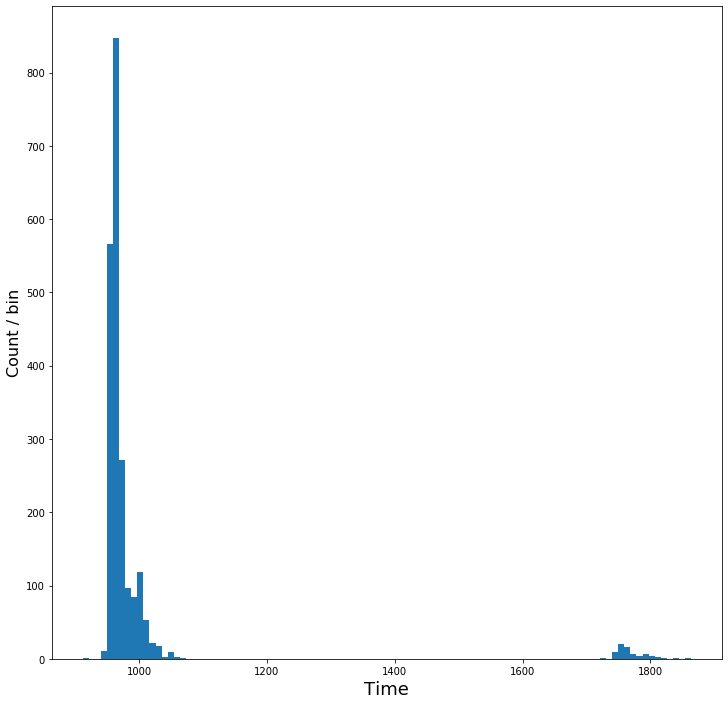

In [23]:
EventDisplayHist( digitimes, "Time")

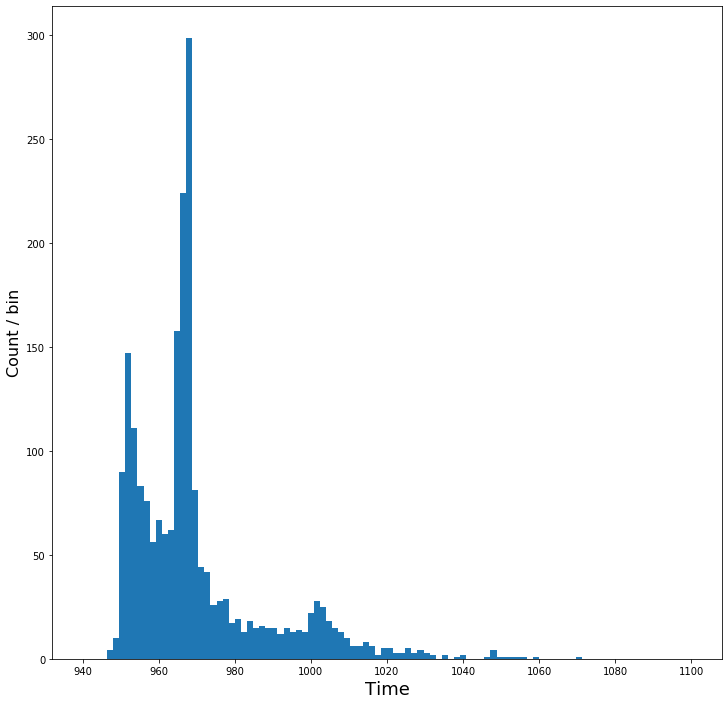

In [24]:
EventDisplayHist( digitimes, "Time", [940,1100])

In [25]:
# Add a 2d histogram of charge versus time

In [26]:
def ChargeTimeHist( times, charges, title='Event Charge versus Time', cutrange = [[-1,-1],[-1,-1]] ):
    """
    Makes a 2d histogram of charge versus time.
    inputs:
    times is an np.array of times of PMT hits
    charges is an np.array of charges of PMT hits
    title is the title of the histogram
    cutrange has two ranges, one in x and one in y [ [tmin, tmax], [qmin,qmax] ]
    """
    fig = plt.figure(figsize=[12,12]) 
    tmin = times.min()
    tmax = times.max()
    qmin = charges.min()
    qmax = charges.max()

    if cutrange[0][0] != cutrange[0][1]:
        tmin = cutrange[0][0]
        tmax = cutrange[0][1]
    if cutrange[1][0] != cutrange[1][1]:
        qmin = cutrange[1][0]
        qmax = cutrange[1][1]
        
    plt.hist2d( times, charges, [100,100], [[tmin,tmax],[qmin,qmax]] )
    fig.suptitle(title, fontsize=20)
    plt.xlabel('Time (ns)', fontsize=18)
    plt.ylabel('Charge (pe)', fontsize=16)
    plt.set_cmap('gist_heat_r')
    plt.colorbar()   
    


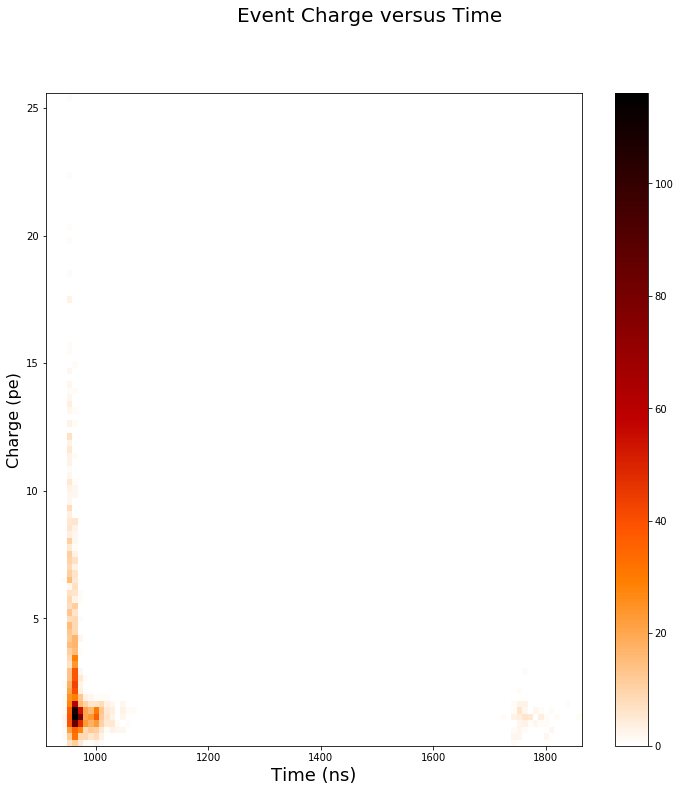

In [27]:
ChargeTimeHist( digitimes, digicharges )

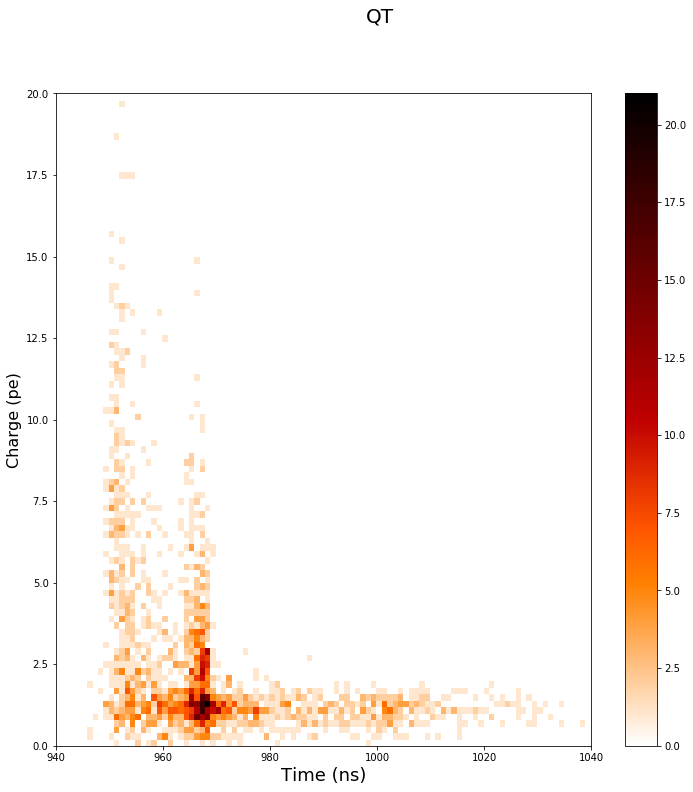

In [28]:
ChargeTimeHist( digitimes, digicharges, 'QT', [[940,1040],[0,20]] )

# Now lets pick 5 random events to display

In [29]:


def GetRandomEvent( ):
    evno = random.randint( 0, number_of_events-1 )
    dgitubes = datafile[ 'digi_hit_pmt' ][ evno ]
    dgicharges = datafile[ 'digi_hit_charge' ][ evno ]
    dgitimes = datafile[ 'digi_hit_time' ][ evno ]    
    return (evno, dgitubes, dgicharges, dgitimes)

def GetEvent( evnum ):
    dgitubes = datafile[ 'digi_hit_pmt' ][ evnum ]
    dgicharges = datafile[ 'digi_hit_charge' ][ evnum ]
    dgitimes = datafile[ 'digi_hit_time' ][ evnum ]    
    return (evnum, dgitubes, dgicharges, dgitimes)

Actually, first let's draw event 124 which has a PMT in the event with PMT number 0

Displaying event number  124


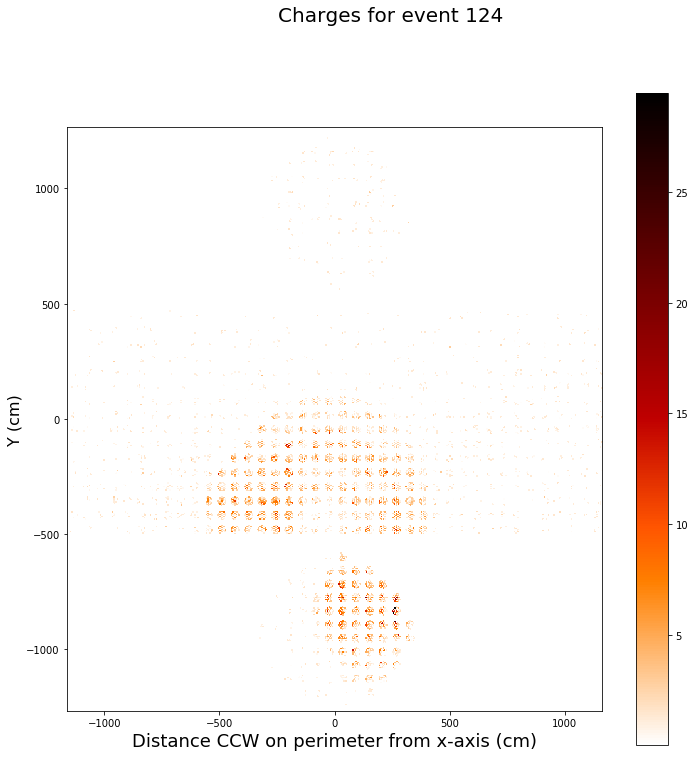

In [30]:
evno, digitubes, digicharges, digitimes = GetEvent( 124 )
print("Displaying event number ",evno)
EventDisplay( digitubes, digicharges, "Charges for event "+str(evno) )      

Displaying event number  1903


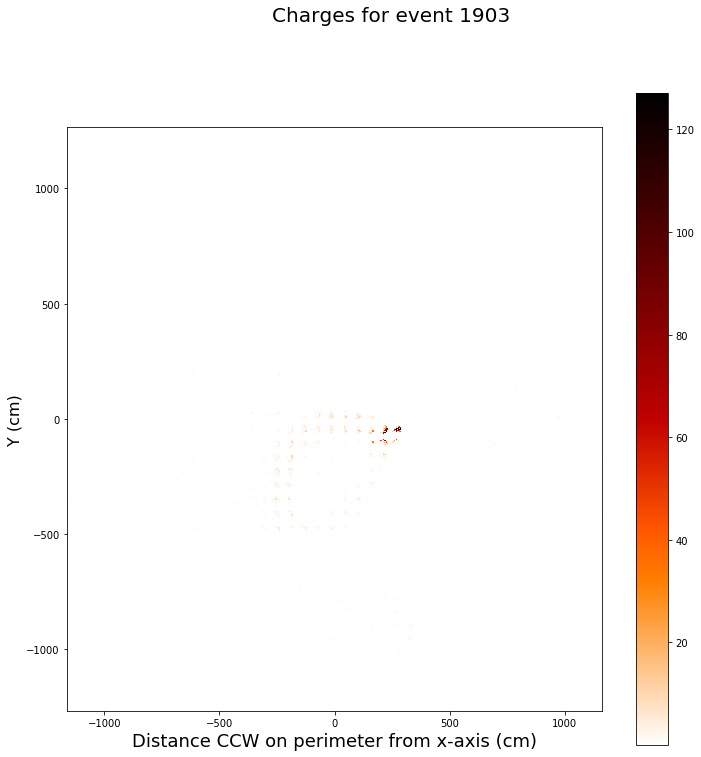

In [31]:
evno, digitubes, digicharges, digitimes = GetRandomEvent()
print("Displaying event number ",evno)
EventDisplay( digitubes, digicharges, "Charges for event "+str(evno) )      

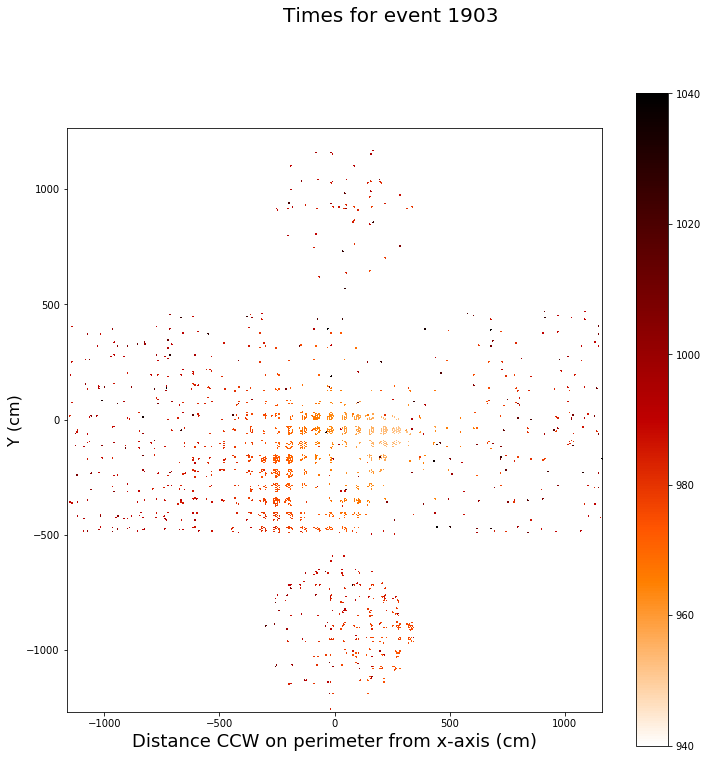

In [32]:
EventDisplay( digitubes, digitimes, "Times for event "+str(evno), [940,1040] ) 

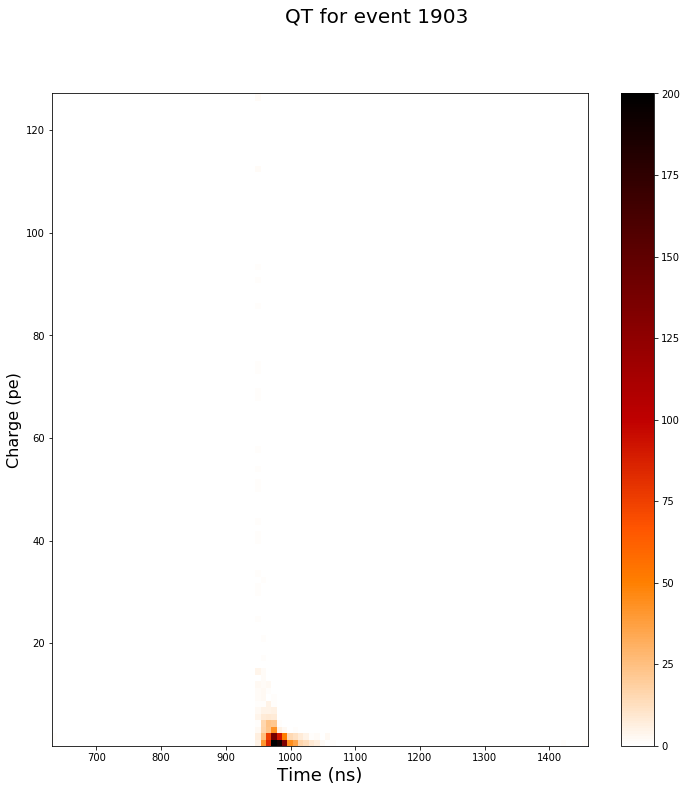

In [33]:
ChargeTimeHist( digitimes, digicharges, "QT for event "+str(evno) )

Displaying event number  1748


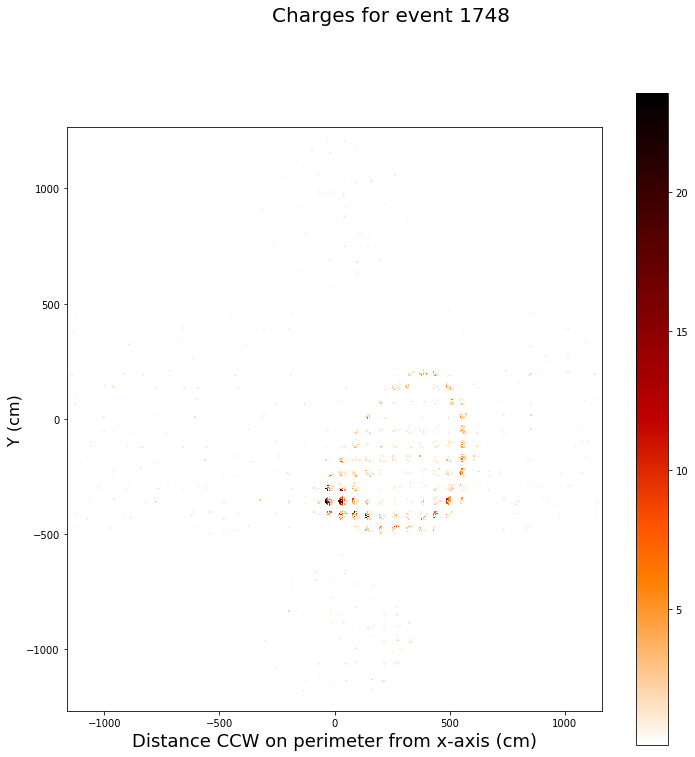

In [34]:
evno, digitubes, digicharges, digitimes = GetRandomEvent()
print("Displaying event number ",evno)
EventDisplay( digitubes, digicharges, "Charges for event "+str(evno) )      

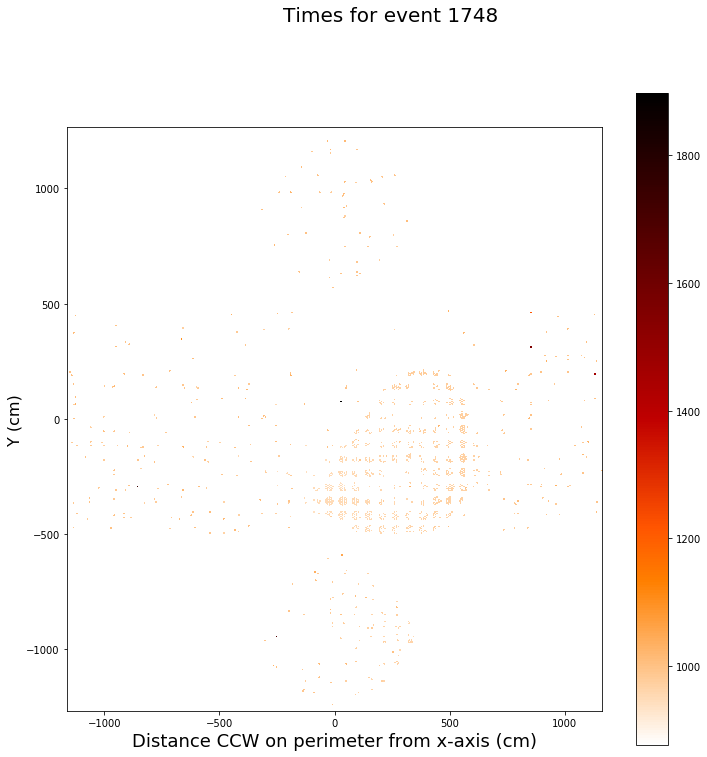

In [35]:
EventDisplay( digitubes, digitimes, "Times for event "+str(evno) ) 

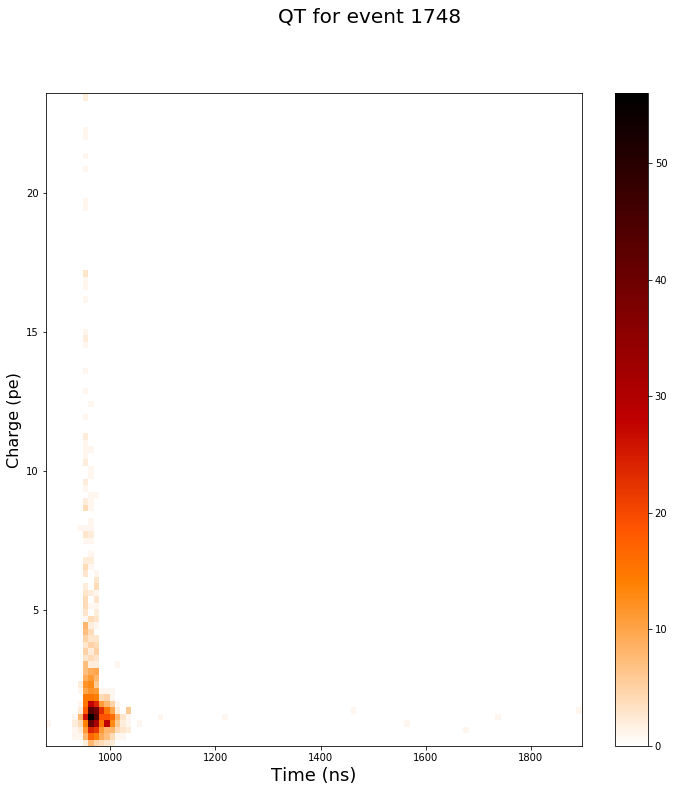

In [36]:
ChargeTimeHist( digitimes, digicharges, "QT for event "+str(evno) )

Displaying event number  2710


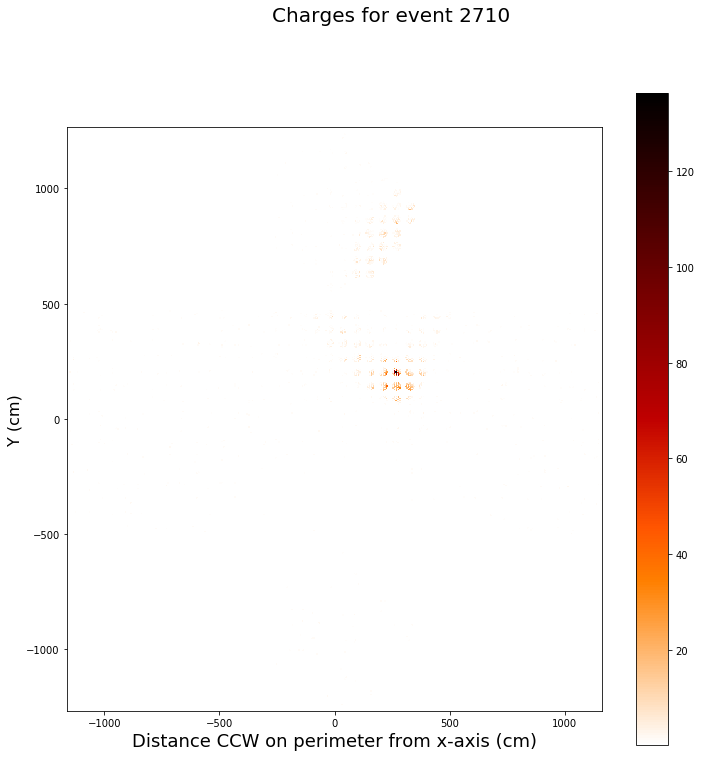

In [37]:
evno, digitubes, digicharges, digitimes = GetRandomEvent()
print("Displaying event number ",evno)
EventDisplay( digitubes, digicharges, "Charges for event "+str(evno) )      

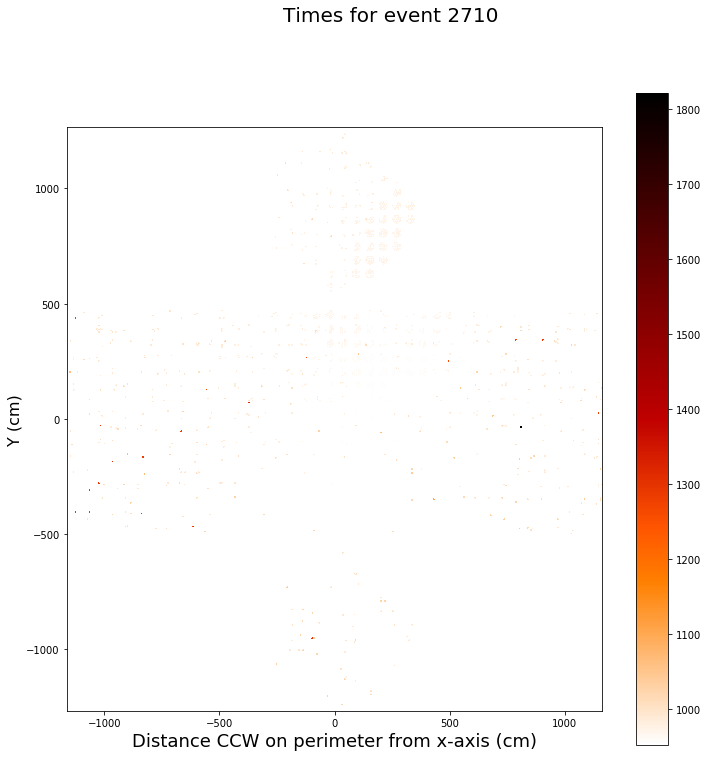

In [38]:
EventDisplay( digitubes, digitimes, "Times for event "+str(evno) ) 

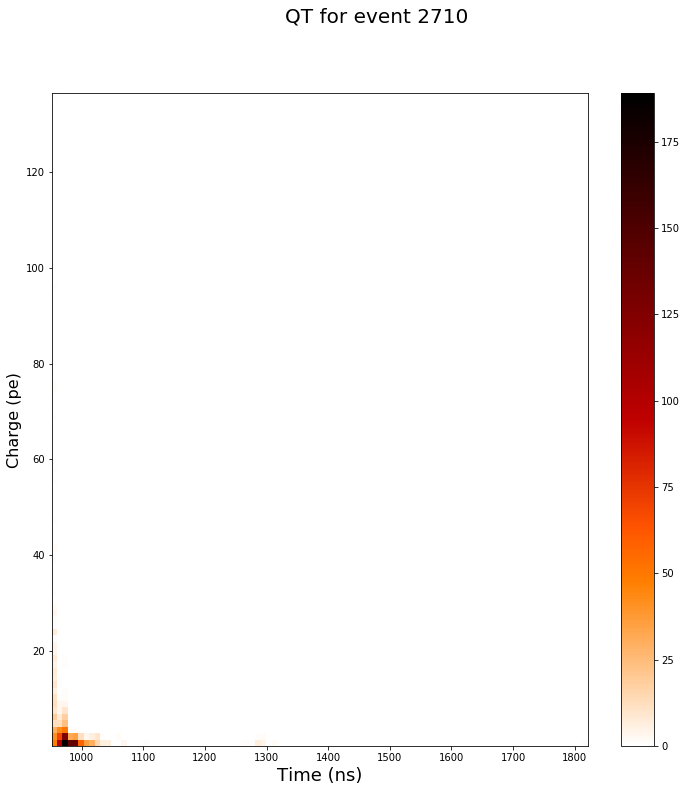

In [39]:
ChargeTimeHist( digitimes, digicharges, "QT for event "+str(evno) )

In [ ]:
evno, digitubes, digicharges, digitimes = GetRandomEvent()
print("Displaying event number ",evno)
EventDisplay( digitubes, digicharges, "Charges for event "+str(evno) )      

In [ ]:
EventDisplay( digitubes, digitimes, "Times for event "+str(evno) ) 

In [ ]:
ChargeTimeHist( digitimes, digicharges, "QT for event "+str(evno) )

In [ ]:
evno, digitubes, digicharges, digitimes = GetRandomEvent()
print("Displaying event number ",evno)
EventDisplay( digitubes, digicharges, "Charge for event "+str(evno) )      

In [ ]:
EventDisplay( digitubes, digitimes, "Times for event "+str(evno) ) 

In [ ]:
ChargeTimeHist( digitimes, digicharges, "QT for event "+str(evno) )